In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab

In [2]:
params = {
    'legend.fontsize': 'large',
    'figure.figsize': (16, 4), # 2.2*len(csvs)
    'axes.labelsize': 'x-large',
    'axes.titlesize':'x-large',
    'xtick.labelsize':'x-large',
    'ytick.labelsize':'x-large',
    'xtick.major.size': 7.0,
    'ytick.major.size': 3.0
}
pylab.rcParams.update(params)

In [3]:
df = pd.read_csv('../csv/uk_house_prices/cluster_selection_fullcov.csv')

In [4]:
df.head()

,seed,N,D,num_clusters,lengthscale_mult,lengthscale,kernel_var,noise_var,method,proj,ctr,feature_dist,rmse,test_kl,test_mnll,test_mean_mse,test_var_mse
0,0.0,10000.0,8.0,1722.0,0.125,0.248995,0.505562,0.201897,rff,gaussian,0.0,None,0.643688,7069.143555,1.144562,0.203645,0.000205
1,0.0,10000.0,8.0,1722.0,0.125,0.248995,0.505562,0.201897,rff,srht,0.0,None,0.658580,7850.782715,1.192859,0.225962,0.000206
2,0.0,10000.0,8.0,1722.0,0.125,0.248995,0.505562,0.201897,maclaurin,rademacher,0.0,"[1, 1, 1, 2, 2]",0.500072,1599.725342,0.737001,0.045782,0.000052
3,0.0,10000.0,8.0,1722.0,0.125,0.248995,0.505562,0.201897,maclaurin,rademacher,1.0,"[1, 1, 1]",0.515146,2079.314941,0.773074,0.060546,0.000047
4,0.0,10000.0,8.0,1722.0,0.125,0.248995,0.505562,0.201897,maclaurin,srht,0.0,"[1, 1, 1, 2, 2]",0.522666,2326.375977,0.793165,0.066252,0.000061


In [3]:
def get_error_over_input(df, config, error_field='test_kl', input_field='lengthscale_mult', D=8.0):
    df_sel = df[(df['proj'] == config['proj']) & (df['method'] == config['method'])]
    df_sel = df_sel[(df_sel['ctr'] == config['ctr'])]
    df_sel = df_sel[(df_sel['D'] == D)]
    
    if config['method'] == 'maclaurin':
        df_sel = df_sel[~df_sel['num_clusters'].isna()]
    
    df_sel = df_sel.groupby([input_field])
    
    cluster_means = df_sel['num_clusters'].mean().values
    error_means = df_sel['test_kl'].mean()
    error_stds = df_sel['test_kl'].std()
    
    return df_sel.groups.keys(), error_means, error_stds, cluster_means

In [71]:
def plot_csv(
    ax, csv_file, configs,
    error_field='rel_frob_error',
    regression=False, y_lim=None,
    logscale=False, title='dataset',
    x_axis=True, ylabel='',
    ylog=False, len_mult=2.0
):
    
    bar_positions = []
    data_names = []
        
    df = pd.read_csv(csv_file)
    df = df[df['D'] > 16.0]
    Ds = np.sort(df['D'].unique())
    df = df[df['D'].isin(Ds)]

    bar_positions = np.arange(len(Ds))
    width = 1./(len(configs)+1)
    
    cluster_mean = 0
    
    for j, (name, config) in enumerate(configs):
        df_sel = df[(df['proj'] == config['proj']) & (df['method'] == config['method'])]
        df_sel = df_sel[(df_sel['ctr'] == config['ctr'])]
        df_sel = df_sel[(df_sel['lengthscale_mult'] == len_mult)]
        
        if config['method'] == 'maclaurin':
            df_sel = df_sel[~df_sel['num_clusters'].isna()]
        
        df_sel = df_sel.groupby(['D'])

        if config['method'] == 'maclaurin':
            cluster_mean = int(df_sel['num_clusters'].mean().values[0])
        error_means = df_sel[error_field].mean()
        error_stds = df_sel[error_field].std()

        ax.bar(
            bar_positions + j*width, error_means,
            yerr=error_stds,
            error_kw=dict(lw=1, capsize=1, capthick=1, alpha=0.3),
            color=config['color'],
            width=width,
            label=name,
            align='edge'
        )

    if x_axis:
        ax.set_xticks(bar_positions+len(configs)*width/2.)
        ax.set_xticklabels([int(D) for D in Ds])
    else:
        ax.set_xticks([])
        ax.set_xticklabels([])

#     if error_field == 'test_kl':
#         ax.yaxis.set_major_formatter(FormatStrFormatter("%.0e"))

    if logscale:
        ax.set_yscale('log')

    if ylabel != '':
        ax.set_ylabel(ylabel)
        
    if y_lim is not None:
        ax.set_ylim(y_lim)
        
    if ylog:
        ax.set_yscale('log')
        
    ax.set_xlabel('Feature Map Dimension ' + r'$D$' + '\n' + '(Using a fixed number of {} clusters)'.format(cluster_mean))

#     ax.legend() # loc='upper center', ncol=8

In [100]:
def plot_abc(ax, csv_file, configs, ylog=False, ylabel='', title=''):
    df = pd.read_csv(csv_file)
    
    for config_name, config in configs:
#         Ds = [8.0, 32.0, 256.0]
        Ds = [32.0, 64.0, 256.0]
    
        for D, linestyle in zip(Ds, ['solid', 'dashed', 'dotted']):
            keys, means, stds, cluster_means = get_error_over_input(df, config, D=D)

            if config_name == 'RFF':
                ax.hlines(
                    means.mean(),
                    xmin=list(keys)[0],
                    xmax=list(keys)[-1],
                    color=config['color'],
                    linewidth=3 if linestyle=='dotted' else 2,
                    linestyle=linestyle,
                    label=config_name + ' (D={})'.format(int(D)),
                    alpha=1.0 #D/128.0
                )
                continue

            ax.plot(
                list(keys),
                means.values,
                label=config_name + ' (D={})'.format(int(D)),
                marker='o',
                linewidth=3 if linestyle=='dotted' else 2,
                linestyle=linestyle,
                markersize=10,
                color=config['color']
            )
            ax.fill_between(
                list(keys),
                means.values-stds.values,
                means.values+stds.values,
                color=config['color'],
                alpha=0.2
            )

#     ax.legend()
    ax.set_xscale('log', basex=2)
    if ylog:
        ax.set_yscale('log')
    ax.set_xticks([key for key in list(keys)[::-1]])
    ax.set_xticklabels([str(key) + r' $l$' + '\n(' + str(int(mean)) + ')' for key, mean in zip(list(keys)[::-1], cluster_means[::-1])])
    ax.set_xlim(2**4, 2**(-3))
    # plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places
    ax.set_xlabel(r'Threshold $\theta$ [in length scales $l$]' + '\n(Avg. Number of Resulting Clusters)')
    ax.set_ylabel(ylabel)
    ax.set_title(title)

In [6]:
colors = plt.get_cmap('tab20c')(np.linspace(0, 0.8, 16)) #[::2]

In [7]:
configs = [
    ('RFF', {'method': 'rff', 'proj': 'gaussian', 'ctr': 0.0, 'color': colors[4]}),
#     ('RFF', {'method': 'rff', 'proj': 'srht', 'ctr': 0.0, 'color': colors[4]}),
    ('Macl. Radem.', {'method': 'maclaurin', 'proj': 'rademacher', 'ctr': 0.0, 'color': colors[9]}),
#     ('Macl. CtR-Radem.', {'method': 'maclaurin', 'proj': 'rademacher', 'ctr': 1.0, 'color': colors[1]}),
    ('Macl. TensorSRHT', {'method': 'maclaurin', 'proj': 'srht', 'ctr': 0.0, 'color': colors[0]}),
#     ('Macl. CtR-SRHT', {'method': 'maclaurin', 'proj': 'srht', 'ctr': 1.0, 'color': colors[3]})
]

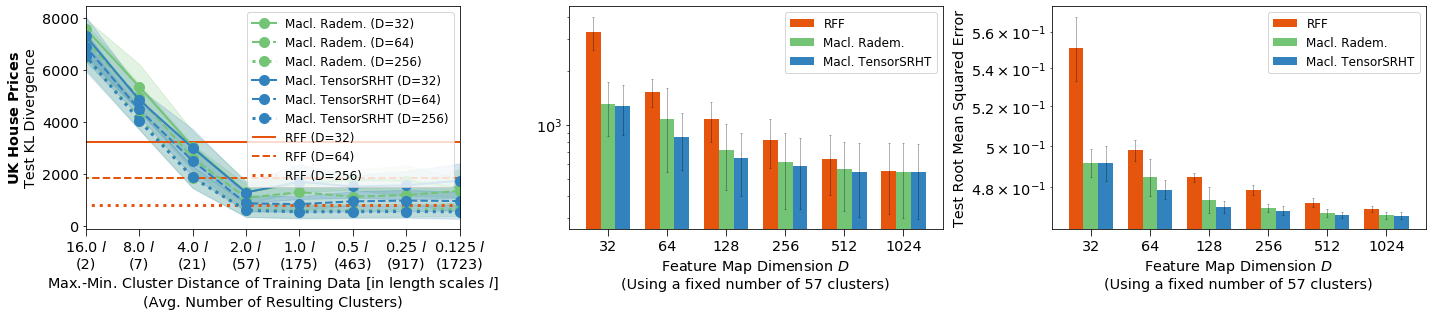

In [96]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,4.5))

plot_abc(axes[0], '../csv/uk_house_prices/cluster_selection_fullcov.csv', configs, ylabel='$\\bf{{UK \ House \ Prices}}$')
plot_csv(axes[1], '../csv/uk_house_prices/cluster_selection_fullcov.csv', configs,
    error_field='test_kl',
    regression=False, y_lim=None,
    logscale=False, title='dataset', ylog=True,
    x_axis=True, ylabel=''
)
plot_csv(axes[2], '../csv/uk_house_prices/cluster_selection_fullcov.csv', configs,
    error_field='rmse',
    regression=False, # y_lim=(0.45, 0.65),
    logscale=False, title='dataset', ylog=True,
    x_axis=True, ylabel='Test Root Mean Squared Error'
)

plt.tight_layout()
plt.savefig('../figures/uk_house_pricing_clusters_vs_features.pdf', dpi=300)
plt.show()

In [101]:
configs = [
    ('RFF', {'method': 'rff', 'proj': 'gaussian', 'ctr': 0.0, 'color': colors[4]}),
    ('RFF (SORF)', {'method': 'rff', 'proj': 'srht', 'ctr': 0.0, 'color': colors[5]}),
#     ('RFF', {'method': 'rff', 'proj': 'srht', 'ctr': 0.0, 'color': colors[4]}),
    ('Macl. Radem.', {'method': 'maclaurin', 'proj': 'rademacher', 'ctr': 0.0, 'color': colors[9]}),
#     ('Macl. CtR-Radem.', {'method': 'maclaurin', 'proj': 'rademacher', 'ctr': 1.0, 'color': colors[1]}),
    ('Macl. TensorSRHT', {'method': 'maclaurin', 'proj': 'srht', 'ctr': 0.0, 'color': colors[0]}),
#     ('Macl. CtR-SRHT', {'method': 'maclaurin', 'proj': 'srht', 'ctr': 1.0, 'color': colors[3]})
]

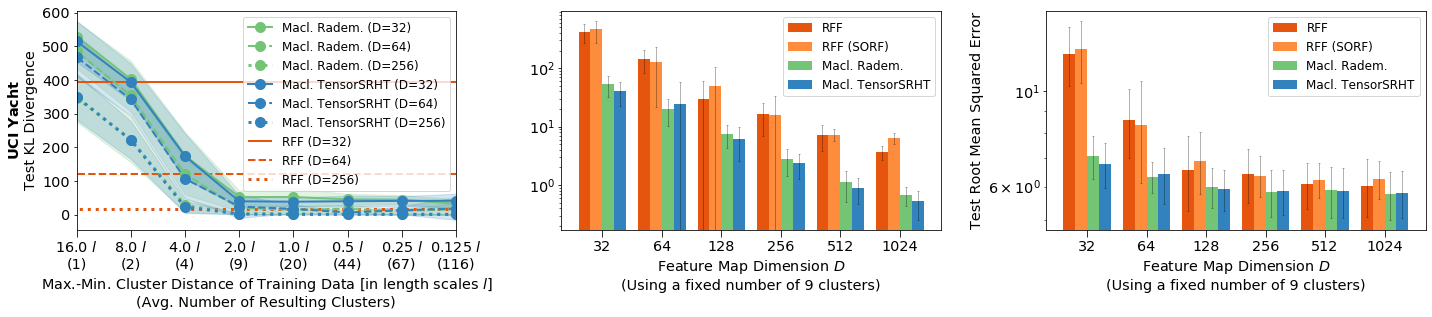

In [94]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20,4.5))

plot_abc(axes[0], '../csv/uci/yacht.csv', list([configs[0]] + configs[2:]), ylog=False, ylabel='$\\bf{{UCI \ Yacht}}$')
plot_csv(axes[1], '../csv/uci/yacht.csv', configs,
    error_field='test_kl',
    regression=False, y_lim=None,
    logscale=False, title='dataset',
    x_axis=True, ylabel='',
    ylog=True
)
plot_csv(axes[2], '../csv/uci/yacht.csv', configs,
    error_field='rmse',
    regression=False, #y_lim=(0.0, 1.0),
    logscale=True, title='dataset',
    x_axis=True, ylabel='Test Root Mean Squared Error'
)

plt.tight_layout()
plt.savefig('../figures/yacht_clusters_vs_features.pdf', dpi=300)
plt.show()

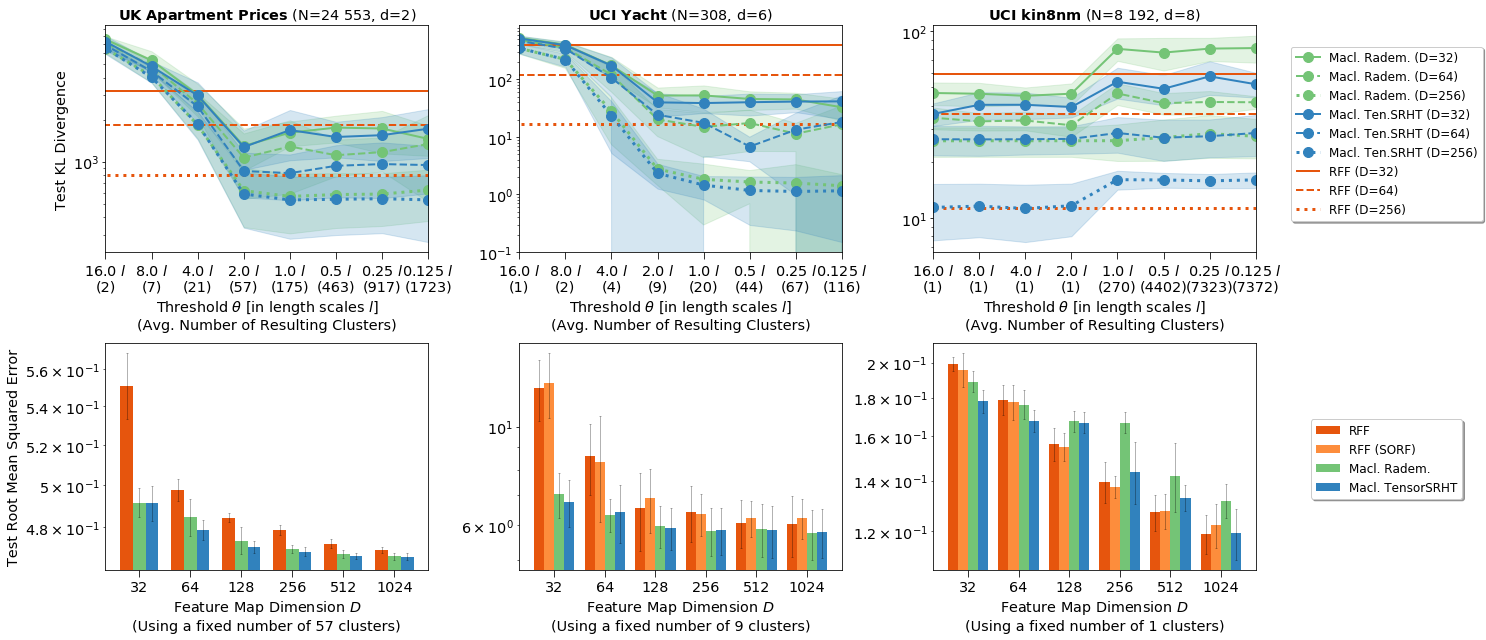

In [102]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18,9))

configs = [
    ('RFF', {'method': 'rff', 'proj': 'gaussian', 'ctr': 0.0, 'color': colors[4]}),
#     ('RFF', {'method': 'rff', 'proj': 'srht', 'ctr': 0.0, 'color': colors[4]}),
    ('Macl. Radem.', {'method': 'maclaurin', 'proj': 'rademacher', 'ctr': 0.0, 'color': colors[9]}),
#     ('Macl. CtR-Radem.', {'method': 'maclaurin', 'proj': 'rademacher', 'ctr': 1.0, 'color': colors[1]}),
    ('Macl. Ten.SRHT', {'method': 'maclaurin', 'proj': 'srht', 'ctr': 0.0, 'color': colors[0]}),
#     ('Macl. CtR-SRHT', {'method': 'maclaurin', 'proj': 'srht', 'ctr': 1.0, 'color': colors[3]})
]

plot_abc(
    axes[0,0],
    '../csv/uk_house_prices/cluster_selection_fullcov.csv',
    configs,
    ylog=True,
    ylabel='Test KL Divergence',
    title='$\\bf{{UK \ Apartment \ Prices}}$' + ' (N=24 553, d=2)'
)

plot_abc(
    axes[0,1],
    '../csv/uci/yacht.csv',
    configs,
    ylog=True,
    ylabel='',
    title='$\\bf{{UCI \ Yacht}}$' + ' (N=308, d=6)'
)

plot_abc(
    axes[0,2],
    '../csv/uci/kin8nm.csv',
    configs,
    ylog=True,
    ylabel='',
    title='$\\bf{{UCI \ kin8nm}}$' + ' (N=8 192, d=8)'
)

configs = [
    ('RFF', {'method': 'rff', 'proj': 'gaussian', 'ctr': 0.0, 'color': colors[4]}),
    ('RFF (SORF)', {'method': 'rff', 'proj': 'srht', 'ctr': 0.0, 'color': colors[5]}),
#     ('RFF', {'method': 'rff', 'proj': 'srht', 'ctr': 0.0, 'color': colors[4]}),
    ('Macl. Radem.', {'method': 'maclaurin', 'proj': 'rademacher', 'ctr': 0.0, 'color': colors[9]}),
#     ('Macl. CtR-Radem.', {'method': 'maclaurin', 'proj': 'rademacher', 'ctr': 1.0, 'color': colors[1]}),
    ('Macl. TensorSRHT', {'method': 'maclaurin', 'proj': 'srht', 'ctr': 0.0, 'color': colors[0]}),
#     ('Macl. CtR-SRHT', {'method': 'maclaurin', 'proj': 'srht', 'ctr': 1.0, 'color': colors[3]})
]

plot_csv(axes[1,0], '../csv/uk_house_prices/cluster_selection_fullcov.csv', list([configs[0]] + configs[2:]),
    error_field='rmse',
    regression=False, #y_lim=(0.0, 1.0),
    logscale=True, title='dataset', len_mult=2.0,
    x_axis=True, ylabel='Test Root Mean Squared Error'
)

plot_csv(axes[1,1], '../csv/uci/yacht.csv', configs,
    error_field='rmse',
    regression=False, #y_lim=(0.0, 1.0),
    logscale=True, title='dataset', len_mult=2.0,
    x_axis=True, ylabel=''
)

plot_csv(axes[1,2], '../csv/uci/kin8nm.csv', configs,
    error_field='rmse',
    regression=False, #y_lim=(0.0, 1.0),
    logscale=True, title='dataset', len_mult=16.0,
    x_axis=True, ylabel=''
)

plt.tight_layout()
handles, labels = axes[0,0].get_legend_handles_labels()
legend1 = plt.figlegend(
    handles=handles, labels=labels,
    loc='upper center', ncol=1, shadow=True, bbox_to_anchor=(1.07, 0.925)
)

handles, labels = axes[1,1].get_legend_handles_labels()
legend2 = plt.figlegend(
    handles=handles, labels=labels,
    loc='upper center', ncol=1, shadow=True, bbox_to_anchor=(1.07, 0.35)
)

plt.savefig('../figures/kl_rmse_plots.pdf', dpi=300, bbox_extra_artists=(legend1,legend2), bbox_inches='tight')
plt.show()